In [1]:
#Importing Packages
import numpy as np
import xarray as xr
from tinygp import kernels, GaussianProcess
import jax
from jax import random
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import create_levels,tinygp_2process_model,truth_posterior_predictive,bias_posterior_predictive,posterior_predictive_realisations

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
#Creating Underlying Process Data 

X1 = np.arange(0,105,2)
X2 = np.arange(0,105,2)

ds = xr.Dataset(
    coords=dict(
        X1=("X1", X1),
        X2=("X2", X2),
    ),
)

ds_stacked = ds.stack(X=('X1', 'X2'))
X = np.array(list(map(np.array, ds_stacked.X.data)))

# #Truth
GP = GaussianProcess(1 * kernels.ExpSquared(10),X,diag=1e-5,mean=1.0)
Y = GP.sample(rng_key)

#Bias
GP2 = GaussianProcess(1 * kernels.ExpSquared(40),X,diag=1e-5,mean=-1.0)
rng_key, rng_key_ = random.split(rng_key)
Y2 = GP2.sample(rng_key)

ds_stacked["Y"]=(['X'],  Y)
ds_stacked["Y2"]=(['X'],  Y2)
ds_stacked["Y3"]=(['X'],  Y+Y2)

ds = ds_stacked.unstack()

In [3]:
#Observations
da_obs = ds.Y.isel(X1=slice(1,None,5),X2=slice(1,None,5))
X1_condition = (ds.X1<25) | (ds.X1>75) 
X2_condition = (ds.X2<25) | (ds.X2>75) 
da_obs = da_obs.where(X1_condition|X2_condition,drop=True)
da_obs_stacked = da_obs.stack(X=('X1', 'X2'))

#Climate model
da_climate = ds.Y3.isel(X1=slice(None,None,5),X2=slice(None,None,5))
da_climate_stacked = da_climate.stack(X=('X1', 'X2'))

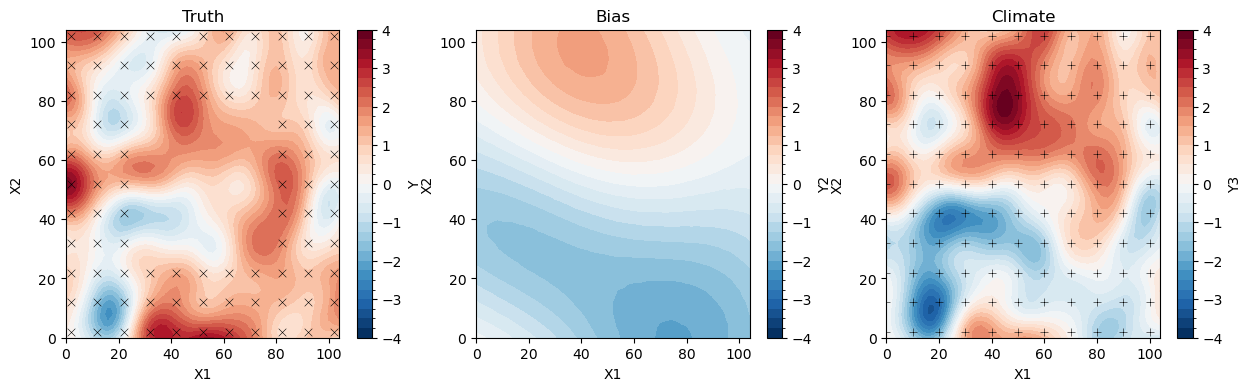

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plots = []
variables = ['Y','Y2','Y3']
titles = ['Truth','Bias','Climate']
levels = create_levels(ds,0.25,0,center=True)

for i,var,title in zip(range(1, 4), variables, titles):
    plt.subplot(1, 3, i)
    plots.append(
        ds[f'{var}'].plot.contourf(x='X1',y='X2',levels=levels,center=0)
    )
    plt.title(title)

axs[0].scatter(da_obs_stacked.dropna('X').X1, da_obs_stacked.dropna('X').X2, s=30, marker='x', c='k')
axs[2].scatter(da_climate_stacked.X1, da_obs_stacked.X2, s=30, marker='+',c='k')

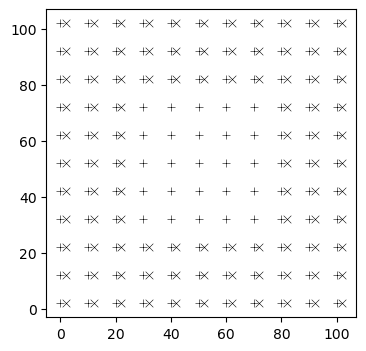

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(da_obs_stacked.dropna('X').X1, da_obs_stacked.dropna('X').X2, s=30, marker='x', c='k')
ax.scatter(da_climate_stacked.X1, da_obs_stacked.X2, s=30, marker='+',c='k')

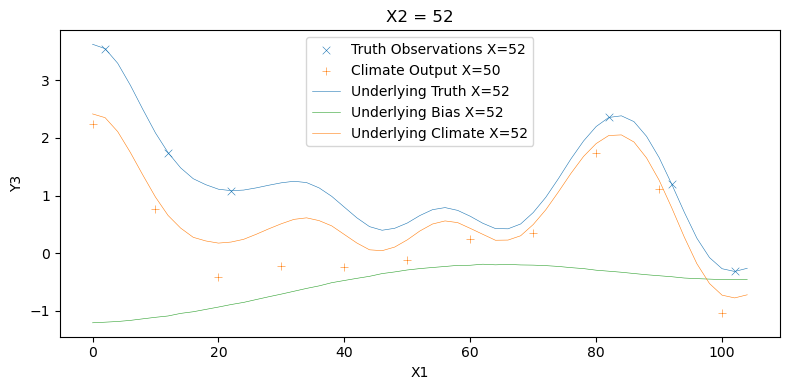

In [6]:
val = 52
cdc = 'tab:orange' #climate_data_colour
odc = 'tab:blue' #observation_data_colour
bdc = 'tab:green'#bias_data_colour

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

da_obs_slice=da_obs.sel(X2=val)
da_climate_slice=da_climate.sel(X2=val,method="nearest")
ax.scatter(da_obs_slice.X1, da_obs_slice.data, s=30, marker='x',c=odc,label = f'Truth Observations X={da_obs_slice.X2.data}')
ax.scatter(da_climate_slice.X1, da_climate_slice.data, s=30, marker='+',c=cdc,label = f'Climate Output X={da_climate_slice.X2.data}')

ds_slice = ds.sel(X2=val)
ds_slice['Y'].plot(label = f'Underlying Truth X={val}',c=odc)
ds_slice['Y2'].plot(label = f'Underlying Bias X={val}',c=bdc)
ds_slice['Y3'].plot(label = f'Underlying Climate X={val}',c=cdc)

plt.legend()
plt.tight_layout()

In [7]:
odata = da_obs_stacked.dropna('X').data
ox = np.array(list(map(np.array, da_obs_stacked.dropna('X').X.data)))
cdata = da_climate_stacked.data
cx = np.array(list(map(np.array, da_climate_stacked.X.data)))

In [8]:
onoise = 1e-5
cnoise = 1e-5

mcmc_2process = run_inference(
    tinygp_2process_model, rng_key_, 1000, 2000,
    cx,ox=ox,cdata=cdata,odata=odata,onoise=onoise,cnoise=cnoise)

sample: 100%|██████████| 3000/3000 [01:16<00:00, 39.26it/s, 7 steps of size 5.15e-01. acc. prob=0.90] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      1.75      0.90      1.56      0.53      2.90   1237.97      1.00
  blengthscale     19.68      3.90     19.21     13.48     25.80   1541.02      1.00
         bmean     -0.30      0.55     -0.32     -1.17      0.60   1925.13      1.00
      kern_var      0.94      0.14      0.93      0.71      1.17   1443.98      1.00
   lengthscale      9.38      0.29      9.39      8.92      9.86   1274.16      1.00
          mean      1.03      0.20      1.02      0.74      1.37   2261.88      1.00

Number of divergences: 0
Time Taken: 80.32855566591024


In [9]:
idata_2process = az.from_numpyro(mcmc_2process)

In [10]:
#Saving Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Examples_Output/'
idata_2process.to_netcdf(f'{outfile_dir}idata_2process_2d.nc')

'/home/jez/Bias_Correction/data/Examples_Output/idata_2process_2d.nc'

In [12]:
#Realisations
ds_predictions = ds.isel(X1=slice(None,None,2),X2=slice(None,None,2))
ds_predictions_stacked = ds_predictions.stack(X=('X1', 'X2'))
nx = np.array(list(map(np.array, ds_predictions_stacked.X.data)))

npr = 20 # num_parameter_realisations
nppr = 20 # num_posterior_pred_realisations

truth_realisations = posterior_predictive_realisations(
    truth_posterior_predictive,
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,
    npr,nppr)

bias_realisations = posterior_predictive_realisations(
    bias_posterior_predictive,
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,
    npr,nppr)

ds_predictions_stacked["mean_truth"]=(['X'],  truth_realisations.mean(axis=(0,1)))
ds_predictions_stacked["std_truth"]=(['X'],  truth_realisations.std(axis=(0,1)))
ds_predictions_stacked["mean_bias"]=(['X'],  bias_realisations.mean(axis=(0,1)))
ds_predictions_stacked["std_bias"]=(['X'],  bias_realisations.std(axis=(0,1)))

ds_predictions = ds_predictions_stacked.unstack()

100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


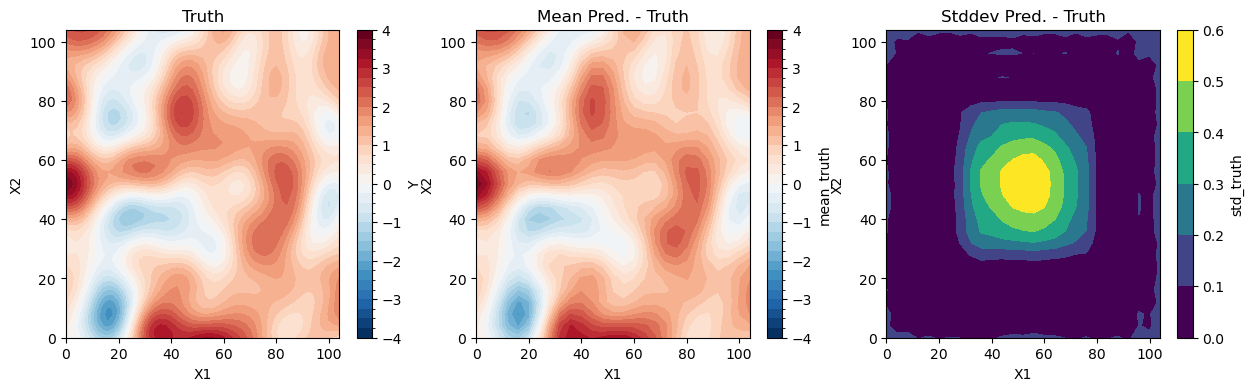

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plots = []
variables = ['mean_truth','std_truth']
titles = ['Mean Pred. - Truth','Stddev Pred. - Truth']
truth_levels = create_levels(ds[['Y']],0.25,0,center=True)
uncertainty_levels = create_levels(ds_predictions[['std_truth']],0.1,1)

plt.subplot(1, 3, 1)
plots.append(ds['Y'].plot.contourf(x='X1',y='X2',levels=truth_levels,ax=axs.flatten()[0]))
plt.title('Truth')

for i,var,title,levels in zip(range(2, 4), variables, titles,[truth_levels,uncertainty_levels]):
    plt.subplot(1, 3, i)
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=levels)
    )
    plt.title(title)

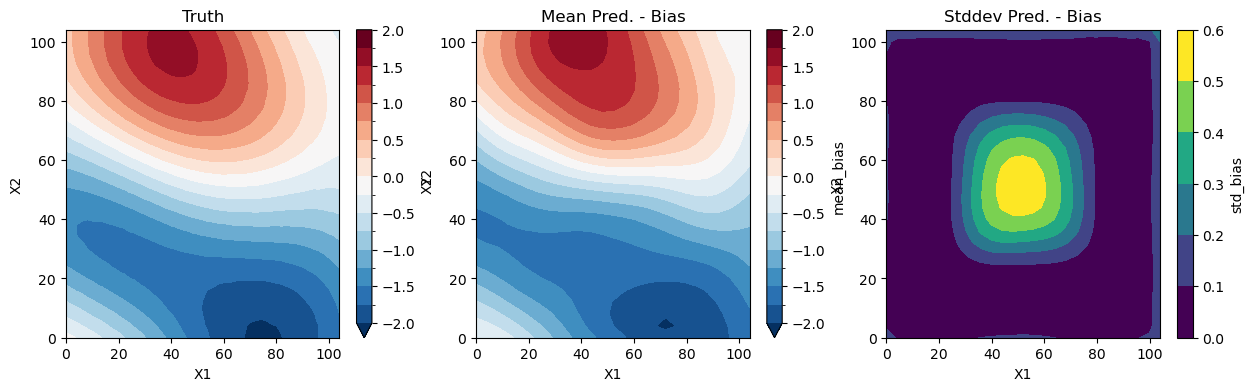

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plots = []
variables = ['mean_bias','std_bias']
titles = ['Mean Pred. - Bias','Stddev Pred. - Bias']
truth_levels = create_levels(ds[['Y2']],0.25,0,center=True)
uncertainty_levels = create_levels(ds_predictions[['std_bias']],0.1,1)

plt.subplot(1, 3, 1)
plots.append(ds['Y2'].plot.contourf(x='X1',y='X2',levels=truth_levels,ax=axs.flatten()[0]))
plt.title('Truth')

for i,var,title,levels in zip(range(2, 4), variables, titles,[truth_levels,uncertainty_levels]):
    plt.subplot(1, 3, i)
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=levels)
    )
    plt.title(title)

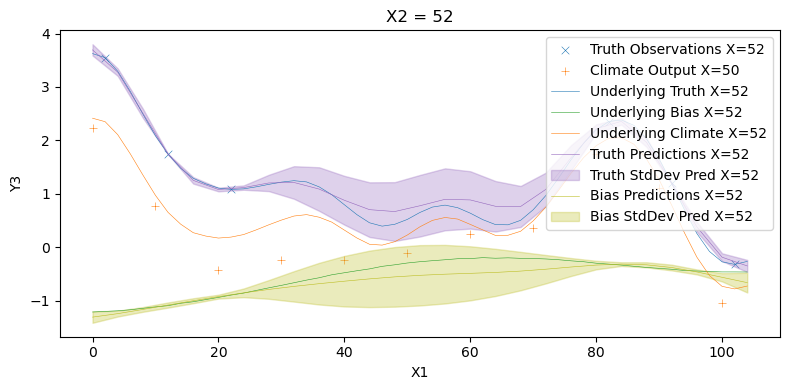

In [15]:
val = 52
cdc = 'tab:orange' #climate_data_colour
odc = 'tab:blue' #observation_data_colour
bdc = 'tab:green'#bias_data_colour
tpdc = 'tab:purple'#truth_prediction_data_colour
bpdc = 'tab:olive'#bias_prediction_data_colour

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

da_obs_slice=da_obs.sel(X2=val)
da_climate_slice=da_climate.sel(X2=val,method="nearest")
ax.scatter(da_obs_slice.X1, da_obs_slice.data, s=30, marker='x',c=odc,label = f'Truth Observations X={da_obs_slice.X2.data}')
ax.scatter(da_climate_slice.X1, da_climate_slice.data, s=30, marker='+',c=cdc,label = f'Climate Output X={da_climate_slice.X2.data}')

ds_slice = ds.sel(X2=val)
ds_slice['Y'].plot(label = f'Underlying Truth X={val}',c=odc)
ds_slice['Y2'].plot(label = f'Underlying Bias X={val}',c=bdc)
ds_slice['Y3'].plot(label = f'Underlying Climate X={val}',c=cdc)

ds_predictions_slice = ds_predictions.sel(X2=val)
truth_mean_pred = ds_predictions_slice['mean_truth'].data
truth_std_pred = ds_predictions_slice['std_truth'].data
bias_mean_pred = ds_predictions_slice['mean_bias'].data
bias_std_pred = ds_predictions_slice['std_bias'].data

ax.plot(ds_predictions_slice.X1, truth_mean_pred, c=tpdc,label = f'Truth Predictions X={val}')
ax.fill_between(ds_predictions_slice.X1,truth_mean_pred+truth_std_pred,truth_mean_pred-truth_std_pred,label=f'Truth StdDev Pred X={val}',color=tpdc,alpha=0.3)
ax.plot(ds_predictions_slice.X1, bias_mean_pred, c=bpdc,label = f'Bias Predictions X={val}')
ax.fill_between(ds_predictions_slice.X1,bias_mean_pred+bias_std_pred,bias_mean_pred-bias_std_pred,label=f'Bias StdDev Pred X={val}',color=bpdc,alpha=0.3)

plt.legend()
plt.tight_layout()